<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:30: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15736\4066691090.py:30: SyntaxWarning: invalid escape sequence '\d'
  DATA_PATH = "E:\daneshgah\quantitative-finance-lab\data\par-yield-curve-rates-1990-2026.csv"


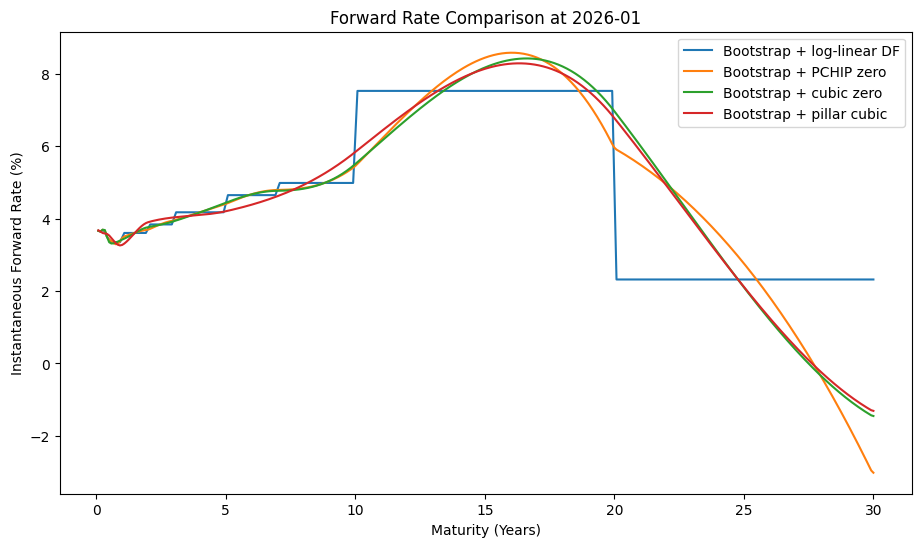

Scenario PnL at base date: 2026-01-31
method                  Bootstrap + PCHIP zero  Bootstrap + cubic zero  \
scenario      maturity                                                   
flattener     2                      -0.019284               -0.019284   
              5                      -0.033017               -0.033017   
              10                     -0.025498               -0.025498   
              30                     -0.043582               -0.043643   
hump_5y       2                       0.000000                0.000000   
              5                      -0.032112               -0.032113   
              10                     -0.005594               -0.005594   
              30                     -0.006368               -0.006369   
parallel_+100 2                      -0.019284               -0.019284   
              5                      -0.044770               -0.044770   
              10                     -0.078021               -0.078023   


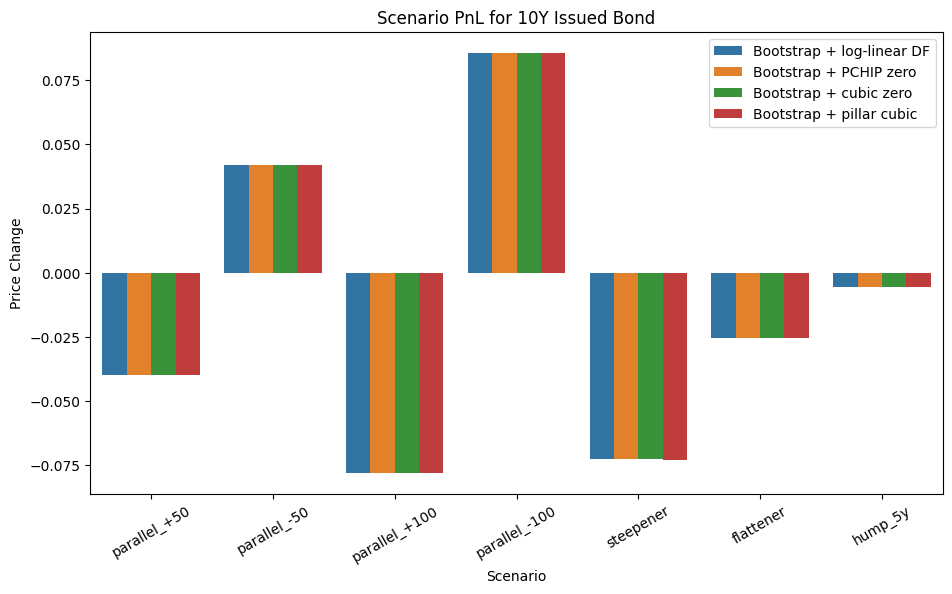

Risk metrics at base date (issued bonds): 2026-01-31
                       method  maturity     price      pv01  \
0   Bootstrap + log-linear DF         2  0.999693  0.000195   
1   Bootstrap + log-linear DF         5  0.997903  0.000458   
2   Bootstrap + log-linear DF        10  0.994283  0.000816   
3   Bootstrap + log-linear DF        30  0.984877  0.001563   
4      Bootstrap + PCHIP zero         2  0.999698  0.000195   
5      Bootstrap + PCHIP zero         5  0.997961  0.000459   
6      Bootstrap + PCHIP zero        10  0.994524  0.000817   
7      Bootstrap + PCHIP zero        30  0.978747  0.001543   
8      Bootstrap + cubic zero         2  0.999701  0.000195   
9      Bootstrap + cubic zero         5  0.997967  0.000459   
10     Bootstrap + cubic zero        10  0.994541  0.000817   
11     Bootstrap + cubic zero        30  0.980083  0.001546   
12   Bootstrap + pillar cubic         2  0.999708  0.000195   
13   Bootstrap + pillar cubic         5  0.997867  0.000458   
14

<Figure size 1100x600 with 0 Axes>

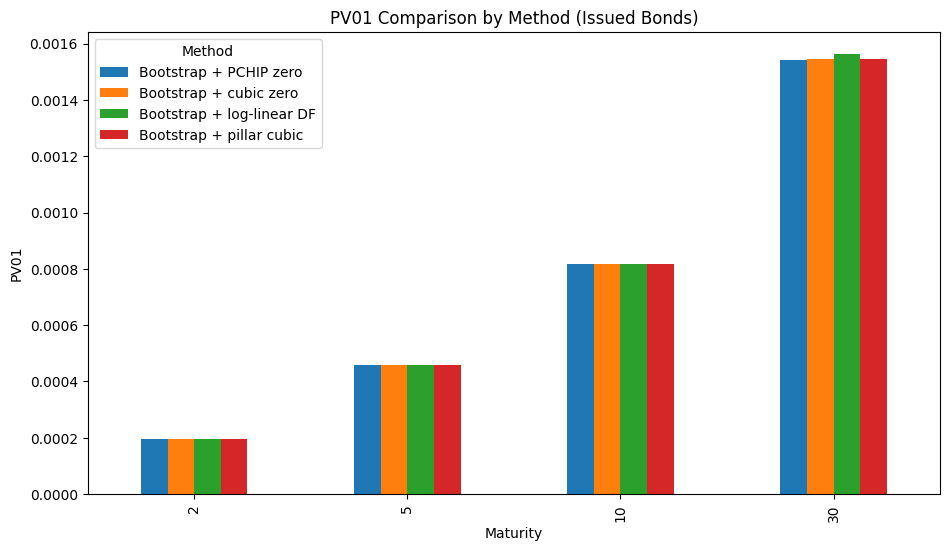

<Figure size 1100x600 with 0 Axes>

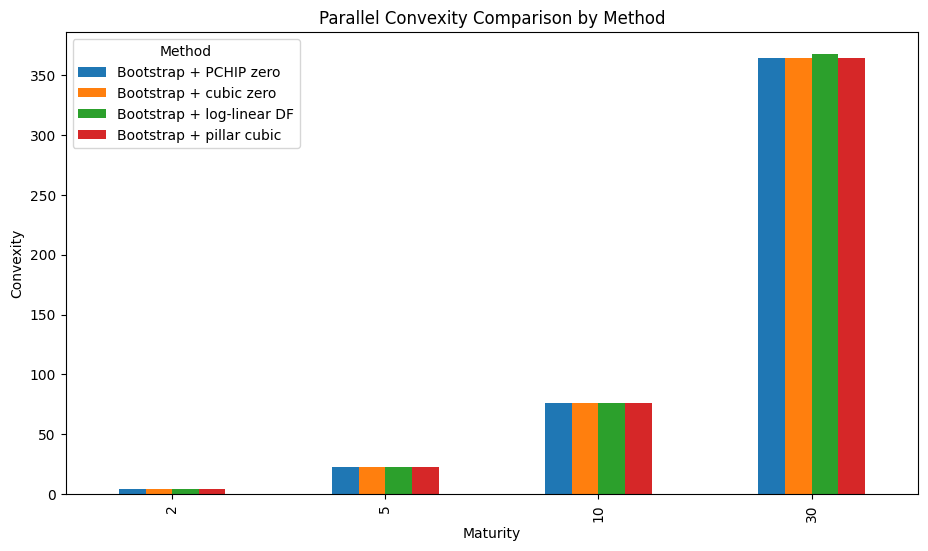

PnL attribution for rolling 10Y book - scenario: steepener
                      method     carry  rolldown  linear_curve  \
0  Bootstrap + log-linear DF  0.266678 -0.895488     -1.743469   
1     Bootstrap + PCHIP zero  0.266678 -0.895873     -1.745567   
2     Bootstrap + cubic zero  0.266678 -0.895889     -1.745750   
3   Bootstrap + pillar cubic  0.266678 -0.896279     -1.748973   

   convexity_other     total  
0        -1.518115 -3.890394  
1        -1.519889 -3.894652  
2        -1.520035 -3.894997  
3        -1.525484 -3.904058  


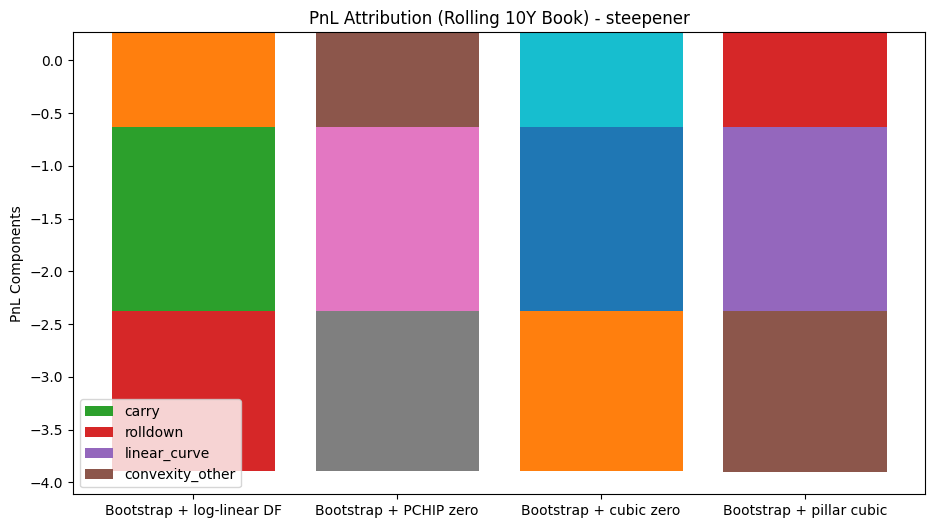

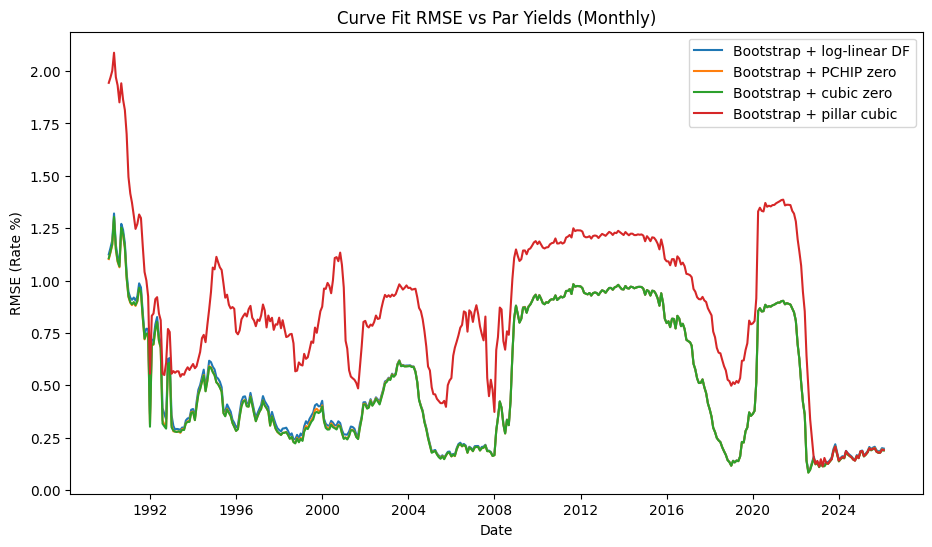

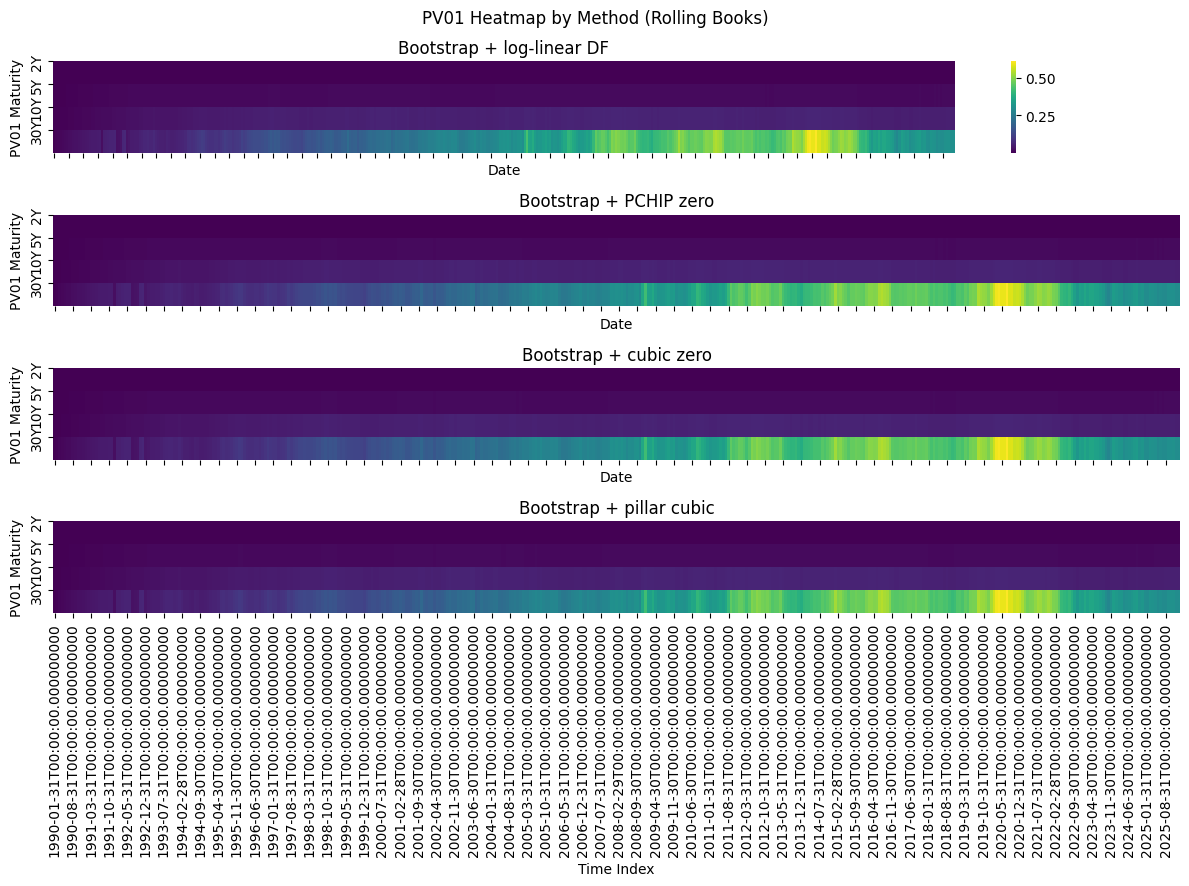

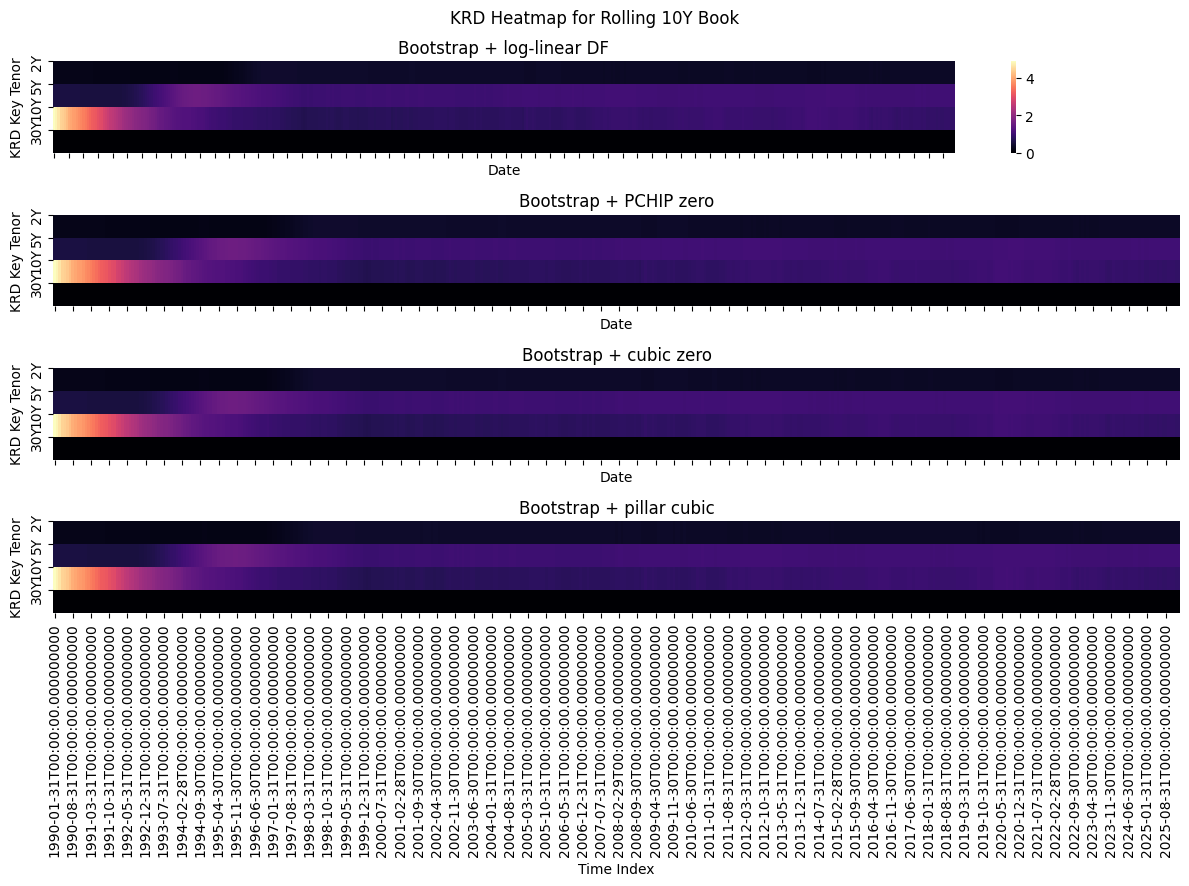

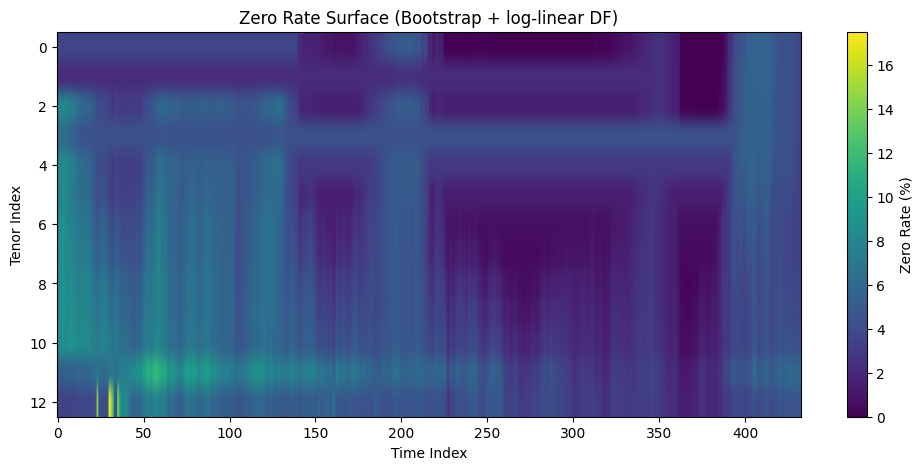

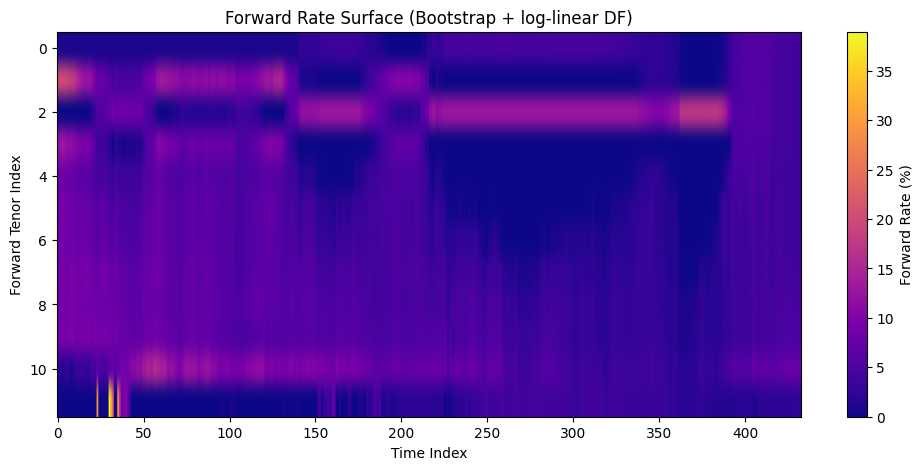

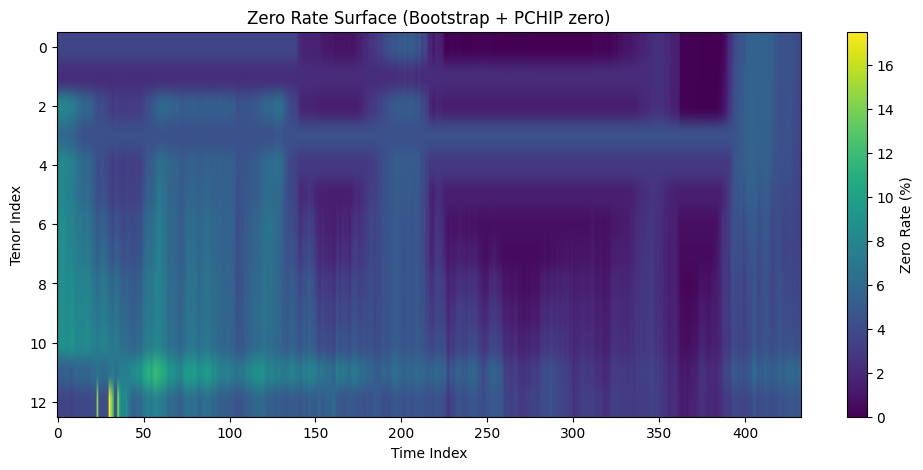

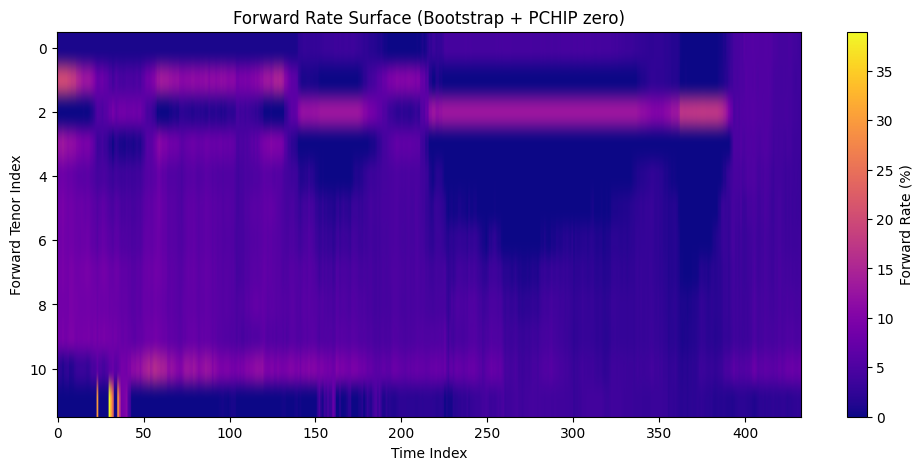

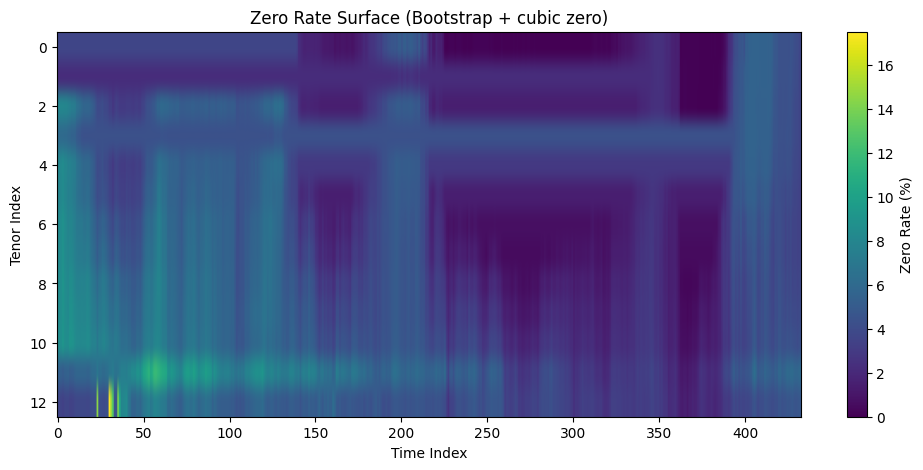

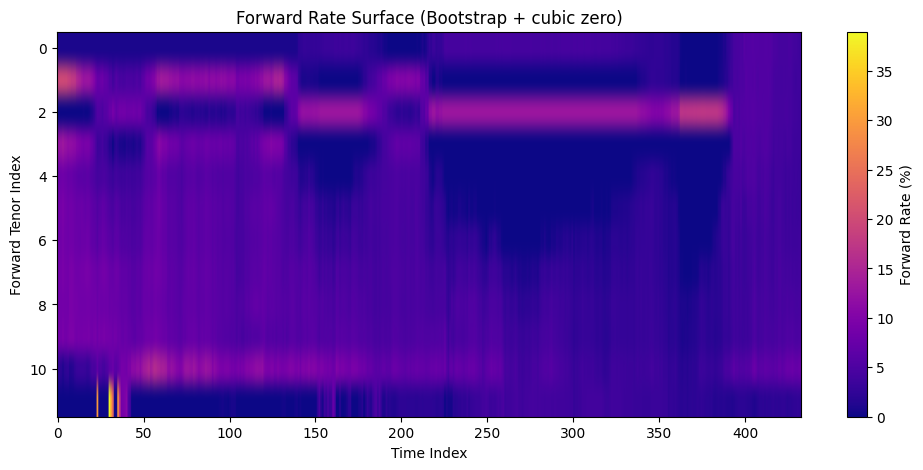

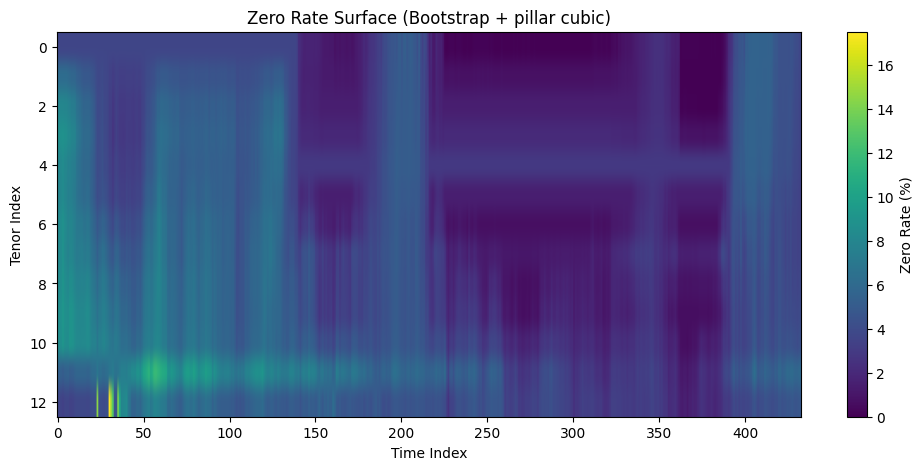

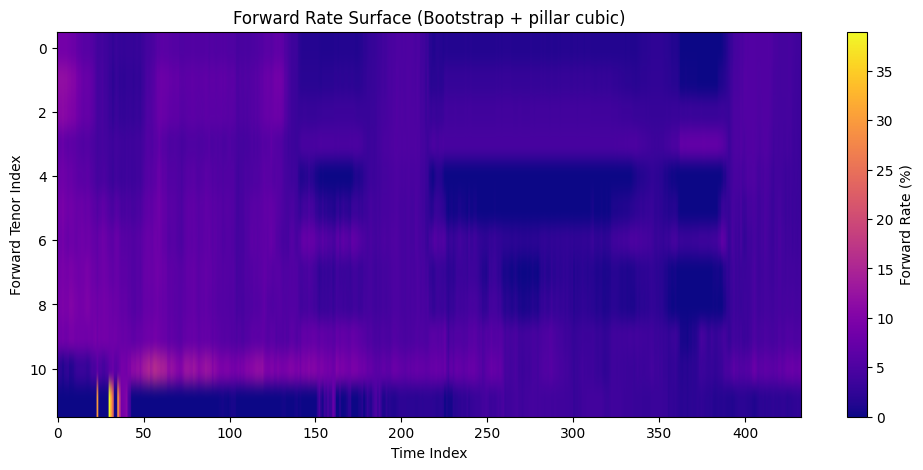

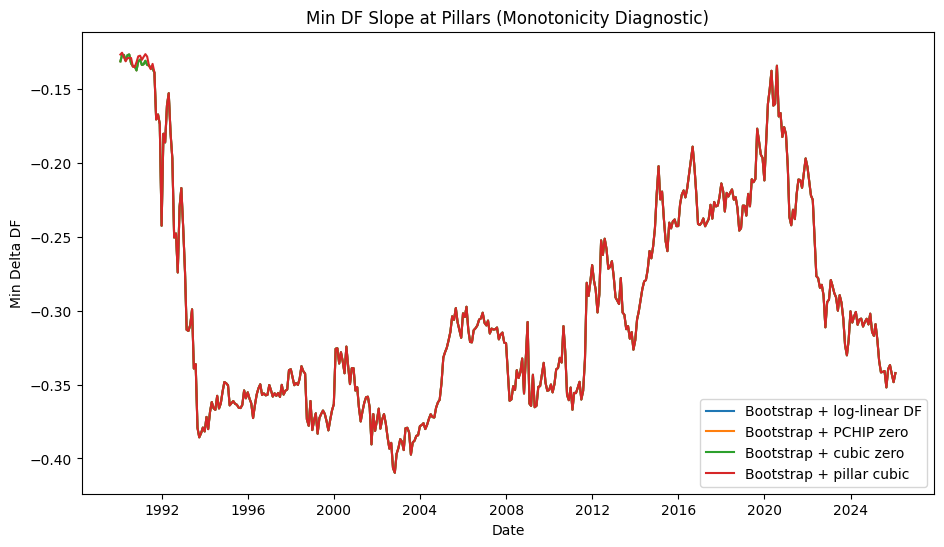

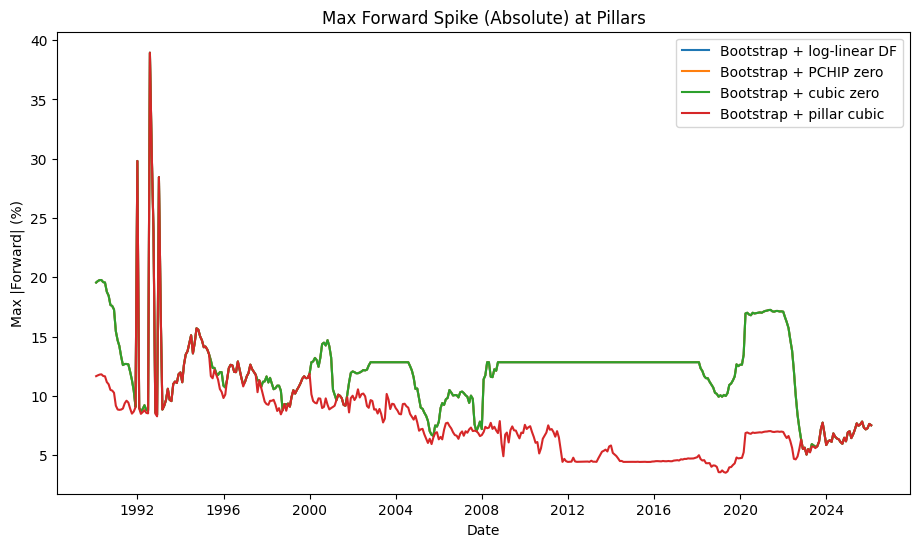

Backtest summary for rolling portfolio
                      method      rmse      corr
0     Bootstrap + PCHIP zero  4.423057  0.940265
1     Bootstrap + cubic zero  4.448181  0.939289
2  Bootstrap + log-linear DF  4.517677  0.936548
3   Bootstrap + pillar cubic  4.470225  0.938145


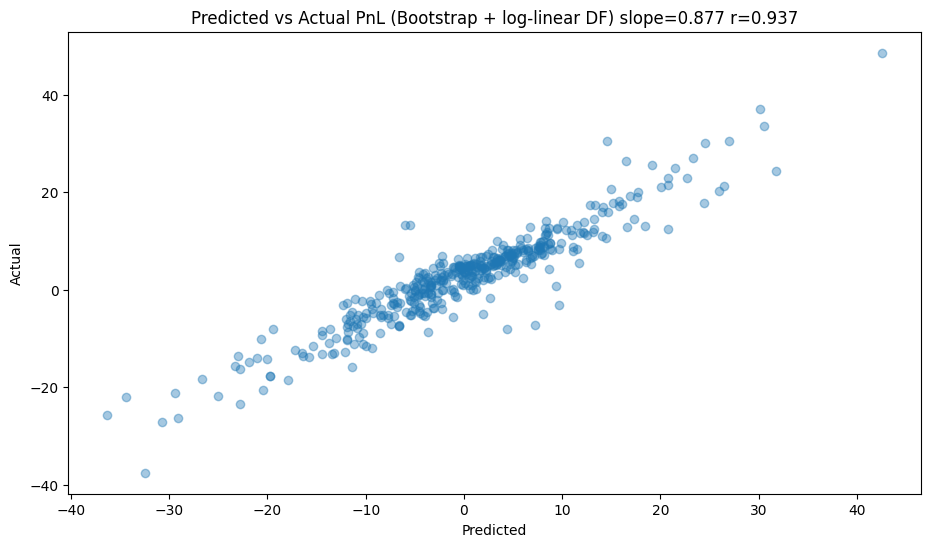

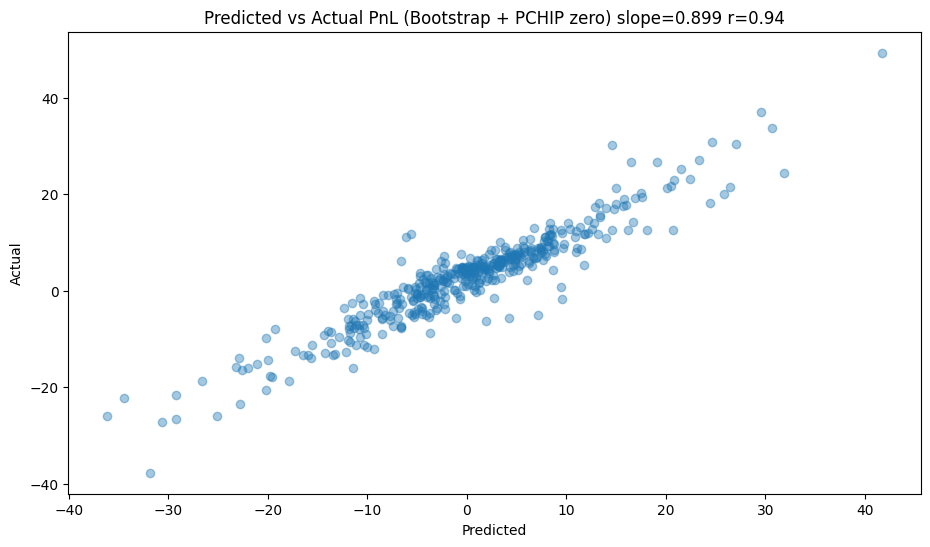

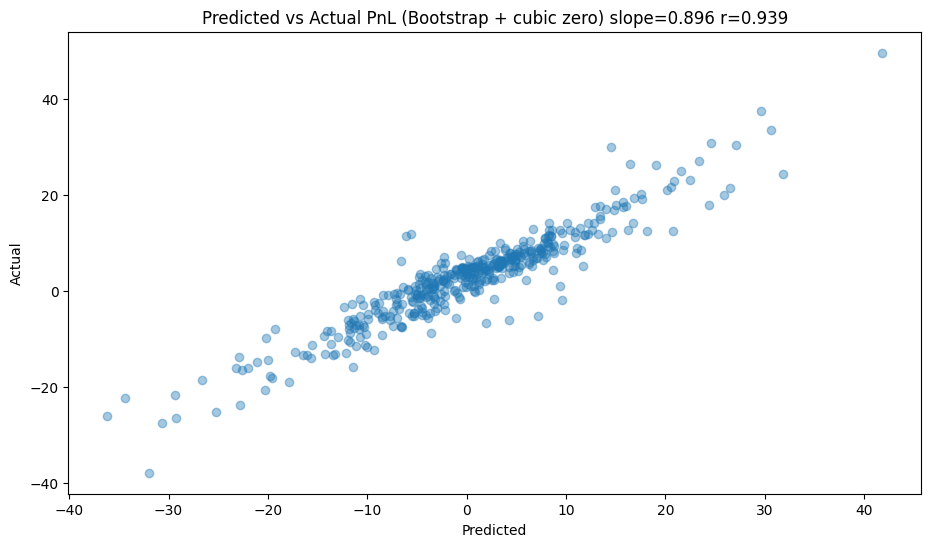

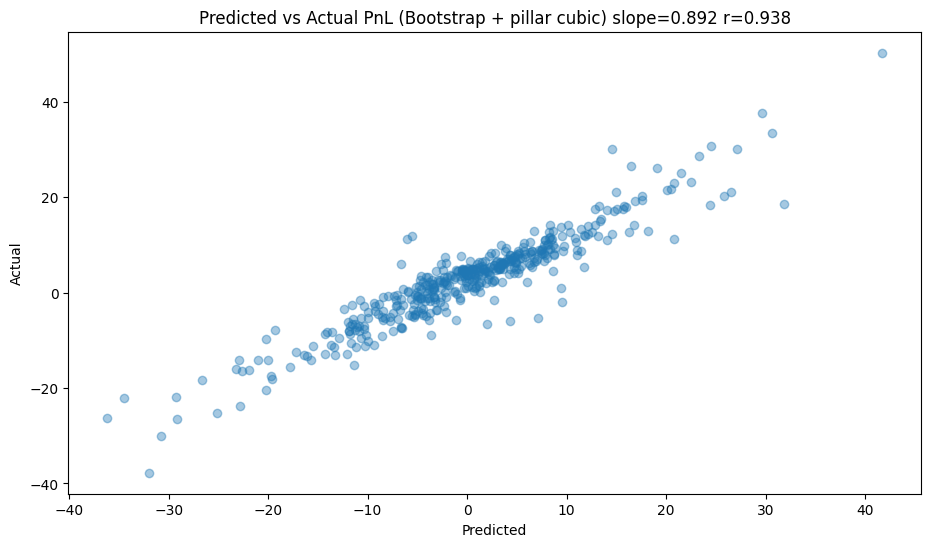

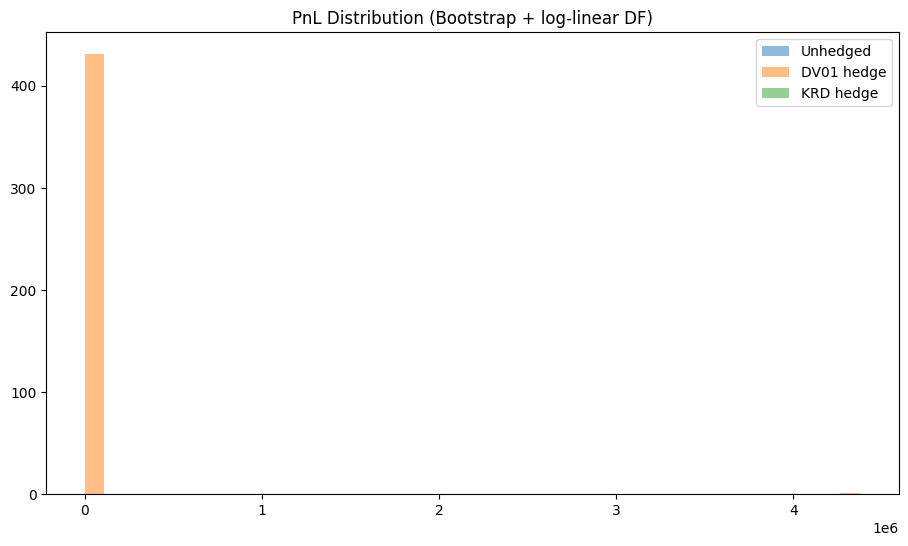

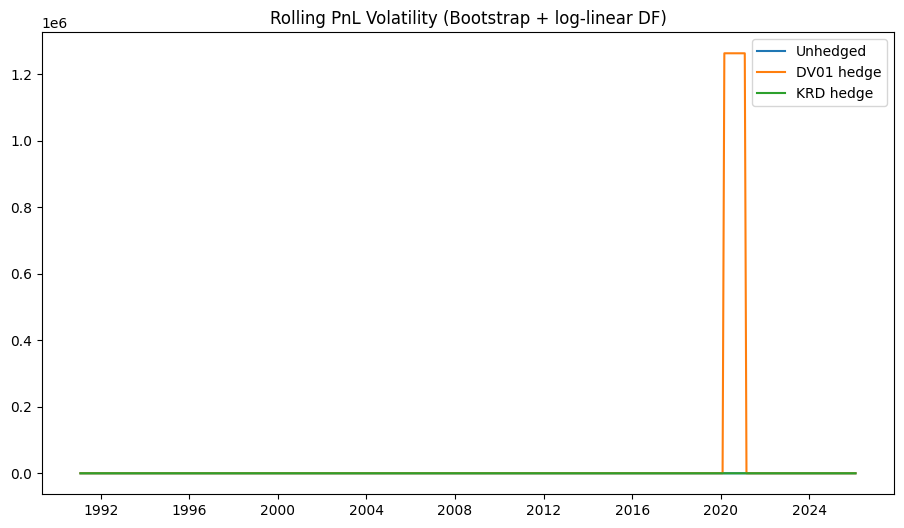

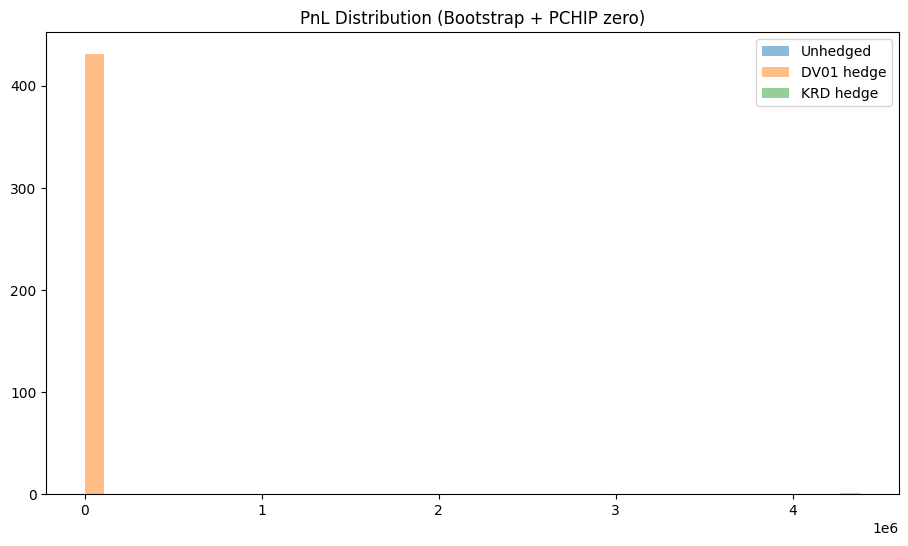

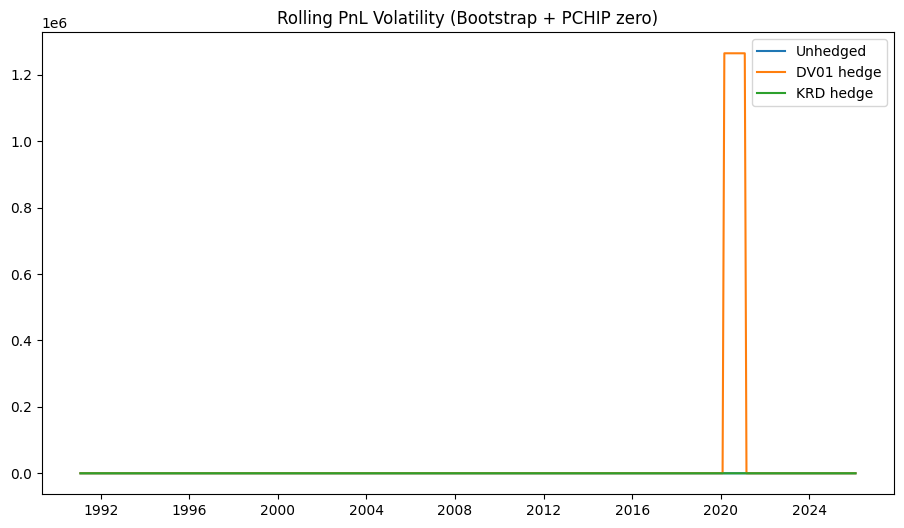

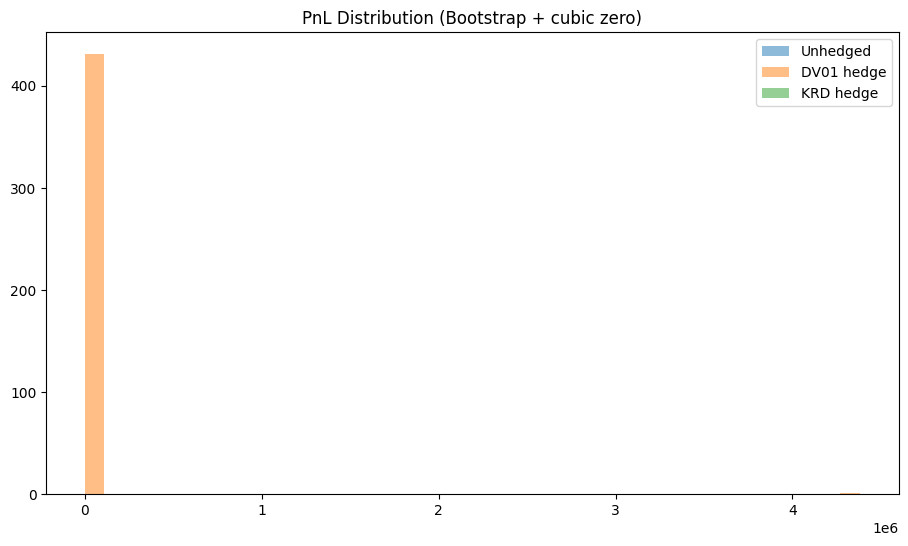

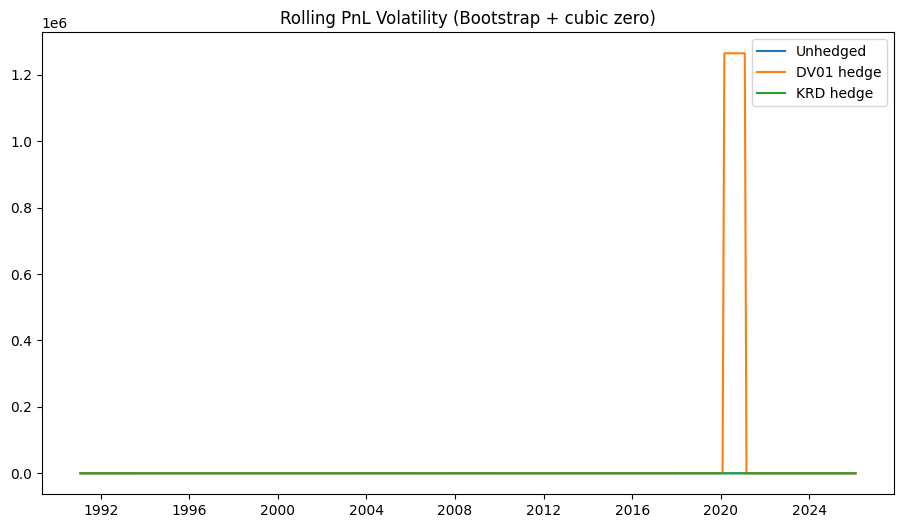

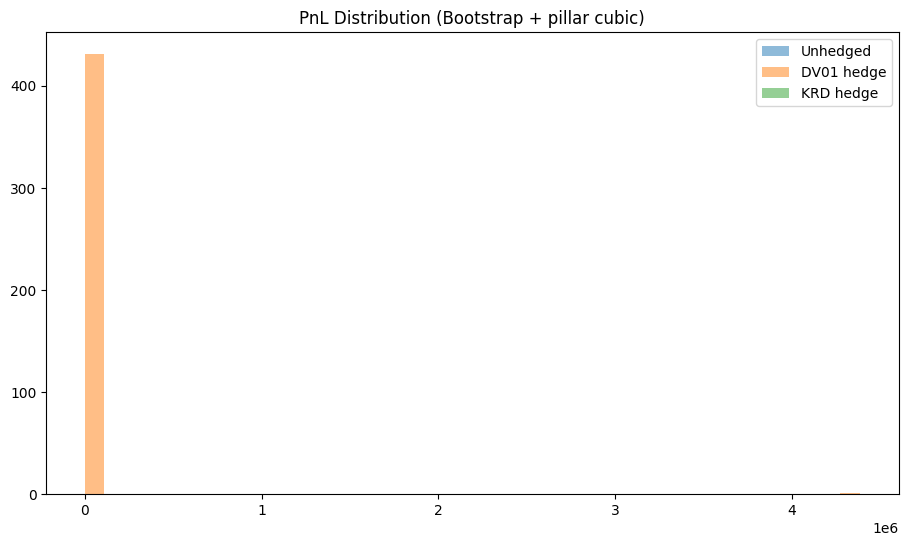

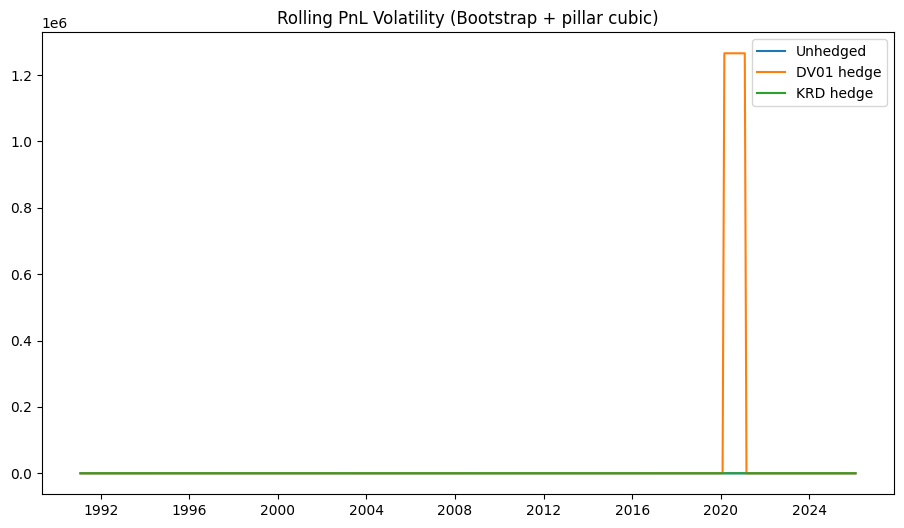

In [1]:
import numpy as np
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (11, 6)

try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except Exception:
    PLOTLY_AVAILABLE = False

try:
    from scipy.interpolate import CubicSpline, PchipInterpolator
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False
    CubicSpline = None
    PchipInterpolator = None

try:
    import seaborn as sns
    SEABORN_AVAILABLE = True
except Exception:
    SEABORN_AVAILABLE = False

DATA_PATH = "E:\daneshgah\quantitative-finance-lab\data\par-yield-curve-rates-1990-2026.csv"
SHORT_END_CONVENTION = "continuous"  # "continuous" or "simple"
ENFORCE_MONOTONIC_DF = True
DAY_COUNT = 365.25
NOTIONAL = 1.0

METHOD_SPECS = [
    ("bootstrap_loglin", "Bootstrap + log-linear DF"),
    ("bootstrap_pchip_zero", "Bootstrap + PCHIP zero"),
    ("bootstrap_cubic_zero", "Bootstrap + cubic zero"),
    ("bootstrap_hybrid_pillar_cubic", "Bootstrap + pillar cubic"),
]
if not SCIPY_AVAILABLE:
    METHOD_SPECS = [("bootstrap_loglin", "Bootstrap + log-linear DF")]


def year_fraction(d0, d1, day_count=DAY_COUNT):
    return (d1 - d0).days / day_count


def tenor_to_years(label):
    label = label.upper().strip()
    if label.endswith("M"):
        return int(label[:-1]) / 12.0
    if label.endswith("Y"):
        return int(label[:-1]) * 1.0
    raise ValueError("Unknown tenor label " + label)


def cashflow_schedule(maturity, freq=2):
    n = int(round(maturity * freq))
    return np.array([i / freq for i in range(1, n + 1)], dtype=float)


def cashflows_from_coupon(times, coupon_rate, freq=2, notional=NOTIONAL):
    cfs = np.full(len(times), coupon_rate / freq * notional, dtype=float)
    cfs[-1] += notional
    return cfs


def remaining_cashflows(times, cfs, elapsed):
    mask = times > elapsed + 1e-8
    if not np.any(mask):
        return np.array([], dtype=float), np.array([], dtype=float)
    return times[mask] - elapsed, cfs[mask]


def price_from_cfs(df_func, times, cfs):
    if len(times) == 0:
        return 0.0
    return float(np.dot(cfs, df_func(times)))


MIN_DF = 1e-10

def bootstrap_discount_factors(par_rates, tenors, short_end_convention=SHORT_END_CONVENTION):
    df_map = {}
    items = sorted(zip(tenors, par_rates), key=lambda x: x[0])
    for T, r in items:
        if T < 1.0:
            if short_end_convention == "continuous":
                df_T = math.exp(-r * T)
            else:
                df_T = 1.0 / (1.0 + r * T)
            if (not np.isfinite(df_T)) or df_T <= 0:
                df_T = math.exp(-r * T) if np.isfinite(r) else 1.0
            df_map[T] = max(df_T, MIN_DF)
            continue
        c = r
        n = int(round(T * 2))
        times = np.array([i / 2 for i in range(1, n + 1)], dtype=float)
        known_times = np.array(sorted(df_map.keys()), dtype=float)
        if known_times.size == 0:
            df_T = math.exp(-r * T) if np.isfinite(r) else 1.0
            df_map[T] = max(df_T, MIN_DF)
            continue
        known_dfs = np.array([df_map[t] for t in known_times], dtype=float)
        known_dfs = np.clip(known_dfs, MIN_DF, None)
        log_known = np.log(known_dfs)

        def interp_df(t):
            if t in df_map:
                return df_map[t]
            log_df = np.interp(t, known_times, log_known, left=log_known[0], right=log_known[-1])
            return float(np.exp(log_df))

        df_coupons = np.array([interp_df(t) for t in times[:-1]], dtype=float)
        df_coupons = np.clip(df_coupons, MIN_DF, None)
        pv_coupons = np.sum((c / 2.0) * df_coupons)
        df_T = (1.0 - pv_coupons) / (1.0 + c / 2.0)
        if (not np.isfinite(df_T)) or df_T <= 0:
            df_T = MIN_DF
        df_map[T] = max(df_T, MIN_DF)
    return np.array([max(df_map[T], MIN_DF) for T in tenors], dtype=float)


def sanitize_dfs(tenors, dfs, par_rates=None, min_df=MIN_DF):
    dfs = np.array(dfs, dtype=float)
    mask = np.isfinite(dfs) & (dfs > min_df)
    if par_rates is not None:
        par_rates = np.array(par_rates, dtype=float)
        fallback = np.exp(-np.clip(par_rates, -0.99, None) * tenors)
    else:
        fallback = np.exp(-0.02 * tenors)
    dfs_clean = np.where(mask, dfs, fallback)
    if np.sum(mask) >= 2:
        log_known = np.log(np.clip(dfs_clean[mask], min_df, None))
        interp = np.exp(np.interp(tenors, tenors[mask], log_known, left=log_known[0], right=log_known[-1]))
        dfs_clean = np.where(mask, dfs_clean, interp)
    return np.clip(dfs_clean, min_df, None)


def make_loglin_df_func(tenors, dfs):
    log_dfs = np.log(np.clip(dfs, MIN_DF, None))

    def df_func(t):
        t = np.array(t, dtype=float)
        log_df = np.interp(t, tenors, log_dfs, left=log_dfs[0], right=log_dfs[-1])
        return np.exp(log_df)

    return df_func


def enforce_monotonic_dfs(tenors, dfs):
    dfs = np.array(dfs, dtype=float)
    dfs = np.clip(dfs, MIN_DF, None)
    violated = np.any(np.diff(dfs) > 1e-10)
    dfs_mono = np.minimum.accumulate(dfs)
    return dfs_mono, violated


def build_curve_from_row(par_rates, tenors, method, hybrid_pillars=None):
    warnings_list = []
    dfs_boot = bootstrap_discount_factors(par_rates, tenors)
    dfs_boot = sanitize_dfs(tenors, dfs_boot, par_rates)
    if ENFORCE_MONOTONIC_DF:
        dfs_boot, violated = enforce_monotonic_dfs(tenors, dfs_boot)
        if violated:
            warnings_list.append("Bootstrap DF monotonicity violated at pillars; enforced monotonic log-linear.")
    zeros_boot = -np.log(dfs_boot) / tenors
    df_func_boot = make_loglin_df_func(tenors, dfs_boot)

    def z_func_from_df(df_func):
        def _z(t):
            t = np.array(t, dtype=float)
            t_safe = np.where(t == 0, 1e-8, t)
            return -np.log(df_func(t_safe)) / t_safe
        return _z

    if method == "bootstrap_loglin":
        return {
            "tenors": tenors,
            "dfs": dfs_boot,
            "zero_rates": zeros_boot,
            "df_func": df_func_boot,
            "z_func": z_func_from_df(df_func_boot),
            "warnings": warnings_list,
        }

    if not SCIPY_AVAILABLE:
        warnings_list.append("SciPy not available; falling back to bootstrap log-linear.")
        return {
            "tenors": tenors,
            "dfs": dfs_boot,
            "zero_rates": zeros_boot,
            "df_func": df_func_boot,
            "z_func": z_func_from_df(df_func_boot),
            "warnings": warnings_list,
        }

    if method == "bootstrap_pchip_zero":
        x = tenors
        y = zeros_boot
        prefer = "pchip"
    elif method == "bootstrap_cubic_zero":
        x = tenors
        y = zeros_boot
        prefer = "cubic"
    elif method == "bootstrap_hybrid_pillar_cubic":
        if hybrid_pillars is None:
            hybrid_pillars = np.array([1 / 12, 3 / 12, 6 / 12, 1, 2, 5, 10, 20, 30], dtype=float)
        x = hybrid_pillars
        y = -np.log(df_func_boot(x)) / x
        prefer = "cubic"
    else:
        raise ValueError("Unknown method " + method)

    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    if x.size < 3:
        warnings_list.append("Not enough finite points for smoothing; falling back to bootstrap log-linear.")
        return {
            "tenors": tenors,
            "dfs": dfs_boot,
            "zero_rates": zeros_boot,
            "df_func": df_func_boot,
            "z_func": z_func_from_df(df_func_boot),
            "warnings": warnings_list,
        }

    if prefer == "pchip":
        try:
            interp = PchipInterpolator(x, y, extrapolate=True)
        except Exception:
            interp = CubicSpline(x, y, bc_type="natural", extrapolate=True)
    else:
        try:
            interp = CubicSpline(x, y, bc_type="natural", extrapolate=True)
        except Exception:
            interp = PchipInterpolator(x, y, extrapolate=True)

    def z_func_spline(t):
        t = np.array(t, dtype=float)
        return np.array(interp(t), dtype=float)

    def df_func_spline(t):
        t = np.array(t, dtype=float)
        return np.exp(-z_func_spline(t) * t)

    dfs = df_func_spline(tenors)
    dfs = sanitize_dfs(tenors, dfs, par_rates)
    if ENFORCE_MONOTONIC_DF:
        dfs_mono, violated = enforce_monotonic_dfs(tenors, dfs)
        if violated:
            warnings_list.append("Smoothed DF monotonicity violated at pillars; enforced monotonic log-linear.")
            df_func = make_loglin_df_func(tenors, dfs_mono)
            z_func = z_func_from_df(df_func)
            dfs = dfs_mono
        else:
            df_func = df_func_spline
            z_func = z_func_spline
    else:
        df_func = df_func_spline
        z_func = z_func_spline

    zeros = -np.log(dfs) / tenors
    return {
        "tenors": tenors,
        "dfs": dfs,
        "zero_rates": zeros,
        "df_func": df_func,
        "z_func": z_func,
        "warnings": warnings_list,
    }


def build_all_curves(par_rates, tenors, method_ids, hybrid_pillars):
    curves = {}
    for method in method_ids:
        curves[method] = build_curve_from_row(par_rates, tenors, method, hybrid_pillars)
    return curves


def par_yield_from_curve(df_func, maturity, freq=2):
    if maturity < 1.0:
        df_T = df_func(maturity)
        return (1.0 / df_T - 1.0) / maturity
    times = cashflow_schedule(maturity, freq)
    dfs = df_func(times)
    df_T = dfs[-1]
    denom = np.sum(dfs)
    return 2.0 * (1.0 - df_T) / denom


def price_issue(df_func, issue, asof_date):
    elapsed = year_fraction(issue["issue_date"], asof_date)
    if elapsed >= issue["maturity"] - 1e-8:
        return 0.0
    times_rem, cfs_rem = remaining_cashflows(issue["times"], issue["cfs"], elapsed)
    return price_from_cfs(df_func, times_rem, cfs_rem)


def price_book(df_func, issues, asof_date):
    total = 0.0
    for issue in issues:
        if issue["issue_date"] > asof_date:
            break
        total += issue.get("weight", 1.0) * price_issue(df_func, issue, asof_date)
    return total


def book_carry(issues, t0, t1):
    dt = year_fraction(t0, t1)
    if dt <= 0:
        return 0.0
    carry = 0.0
    for issue in issues:
        if issue["issue_date"] > t0:
            break
        elapsed = year_fraction(issue["issue_date"], t0)
        if elapsed < issue["maturity"] - 1e-8:
            carry += issue.get("weight", 1.0) * issue["coupon"] * dt
    return carry


def pv01_parallel_book(curve, issues, asof_date, bp=1.0):
    shift = bp / 10000.0
    z = curve["z_func"]
    P0 = price_book(curve["df_func"], issues, asof_date)
    df_up = lambda t: np.exp(-(z(t) + shift) * np.array(t, dtype=float))
    P_up = price_book(df_up, issues, asof_date)
    return P0 - P_up, P0


def convexity_parallel_book(curve, issues, asof_date, bp=1.0):
    shift = bp / 10000.0
    z = curve["z_func"]
    P0 = price_book(curve["df_func"], issues, asof_date)
    df_up = lambda t: np.exp(-(z(t) + shift) * np.array(t, dtype=float))
    df_dn = lambda t: np.exp(-(z(t) - shift) * np.array(t, dtype=float))
    P_up = price_book(df_up, issues, asof_date)
    P_dn = price_book(df_dn, issues, asof_date)
    if P0 == 0:
        return 0.0
    return (P_dn + P_up - 2.0 * P0) / (P0 * (shift ** 2))


def make_key_rate_bumps(keys):
    keys = np.array(sorted(keys), dtype=float)
    mids = (keys[:-1] + keys[1:]) / 2.0
    if len(keys) > 1:
        left_edge = max(1 / 12, keys[0] - (mids[0] - keys[0]))
        right_edge = keys[-1] + (keys[-1] - mids[-1])
    else:
        left_edge = max(1 / 12, keys[0] * 0.5)
        right_edge = keys[0] * 1.5
    edges = np.concatenate(([left_edge], mids, [right_edge]))

    bump_funcs = []
    for i, key in enumerate(keys):
        left = edges[i]
        right = edges[i + 1]
        center = key

        def bump(t, left=left, right=right, center=center):
            t = np.array(t, dtype=float)
            y = np.zeros_like(t)
            if center > left:
                left_mask = (t >= left) & (t <= center)
                y[left_mask] = (t[left_mask] - left) / (center - left)
            if right > center:
                right_mask = (t > center) & (t <= right)
                y[right_mask] = (right - t[right_mask]) / (right - center)
            return y

        bump_funcs.append(bump)
    return bump_funcs, edges


def key_rate_duration_book(curve, issues, asof_date, key_tenors, bump_funcs, bp=1.0):
    shift = bp / 10000.0
    z = curve["z_func"]
    P0 = price_book(curve["df_func"], issues, asof_date)
    krd = {}
    for key, bump in zip(key_tenors, bump_funcs):
        df_bump = lambda t, bump=bump: np.exp(-(z(t) + shift * bump(t)) * np.array(t, dtype=float))
        P_up = price_book(df_bump, issues, asof_date)
        krd[key] = (P0 - P_up) / (P0 * shift) if P0 != 0 else 0.0
    return krd, P0


def key_rate_convexity_book(curve, issues, asof_date, key_tenors, bump_funcs, bp=1.0):
    shift = bp / 10000.0
    z = curve["z_func"]
    P0 = price_book(curve["df_func"], issues, asof_date)
    conv = {}
    for key, bump in zip(key_tenors, bump_funcs):
        df_up = lambda t, bump=bump: np.exp(-(z(t) + shift * bump(t)) * np.array(t, dtype=float))
        df_dn = lambda t, bump=bump: np.exp(-(z(t) - shift * bump(t)) * np.array(t, dtype=float))
        P_up = price_book(df_up, issues, asof_date)
        P_dn = price_book(df_dn, issues, asof_date)
        conv[key] = (P_up + P_dn - 2.0 * P0) / (P0 * (shift ** 2)) if P0 != 0 else 0.0
    return conv


def make_shift_function(scenario):
    if scenario == "parallel_+50":
        return lambda t: 0.005
    if scenario == "parallel_-50":
        return lambda t: -0.005
    if scenario == "parallel_+100":
        return lambda t: 0.01
    if scenario == "parallel_-100":
        return lambda t: -0.01
    if scenario == "steepener":
        xs = np.array([0.25, 2, 10, 30], dtype=float)
        ys = np.array([0.0025, 0.0025, 0.01, 0.01], dtype=float)
        return lambda t: np.interp(t, xs, ys, left=ys[0], right=ys[-1])
    if scenario == "flattener":
        xs = np.array([0.25, 2, 10, 30], dtype=float)
        ys = np.array([0.01, 0.01, 0.0025, 0.0025], dtype=float)
        return lambda t: np.interp(t, xs, ys, left=ys[0], right=ys[-1])
    if scenario == "hump_5y":
        xs = np.array([0.5, 2, 5, 10, 30], dtype=float)
        ys = np.array([0.0, 0.0, 0.0075, 0.0, 0.0], dtype=float)
        return lambda t: np.interp(t, xs, ys, left=ys[0], right=ys[-1])
    raise ValueError("Unknown scenario " + scenario)


def price_under_shift(curve, issues, asof_date, shift_func):
    z = curve["z_func"]
    df_scn = lambda t: np.exp(-(z(t) + shift_func(t)) * np.array(t, dtype=float))
    return price_book(df_scn, issues, asof_date)


def pnl_attribution_with_convexity(curve, issues, asof_date, shift_func, key_tenors, bump_funcs, horizon=1 / 12):
    P0 = price_book(curve["df_func"], issues, asof_date)
    t1 = asof_date + pd.Timedelta(days=int(horizon * DAY_COUNT))
    P_roll = price_book(curve["df_func"], issues, t1)
    carry = book_carry(issues, asof_date, t1)
    z = curve["z_func"]
    df_scn = lambda t: np.exp(-(z(t) + shift_func(t)) * np.array(t, dtype=float))
    P_scn = price_book(df_scn, issues, t1)
    total = P_scn - P0 + carry
    rolldown = P_roll - P0
    curve_move = P_scn - P_roll
    krd, _ = key_rate_duration_book(curve, issues, asof_date, key_tenors, bump_funcs)
    shifts = np.array([shift_func(k) for k in key_tenors], dtype=float)
    linear_curve = -P0 * np.sum(np.array([krd[k] for k in key_tenors]) * shifts) if P0 != 0 else 0.0
    convexity_other = curve_move - linear_curve
    return {
        "total": total,
        "carry": carry,
        "rolldown": rolldown,
        "linear_curve": linear_curve,
        "convexity_other": convexity_other,
    }

# Load data

df_raw = pd.read_csv(DATA_PATH)
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

col_map = {
    "date": "Date",
    "1 mo": "1M",
    "2 mo": "2M",
    "3 mo": "3M",
    "4 mo": "4M",
    "6 mo": "6M",
    "1 yr": "1Y",
    "2 yr": "2Y",
    "3 yr": "3Y",
    "5 yr": "5Y",
    "7 yr": "7Y",
    "10 yr": "10Y",
    "20 yr": "20Y",
    "30 yr": "30Y",
}

df = df_raw.rename(columns=col_map)
if "Date" not in df.columns:
    raise ValueError("Date column not found after renaming")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).set_index("Date").sort_index()

tenor_labels = ["1M", "2M", "3M", "4M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]
missing = [c for c in tenor_labels if c not in df.columns]
if len(missing) > 0:
    raise ValueError("Missing tenor columns: " + ", ".join(missing))

for col in tenor_labels:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.interpolate(method="time", limit_direction="both")
df = df.dropna(subset=tenor_labels, how="any")
df[tenor_labels] = df[tenor_labels] / 100.0

tenors = np.array([tenor_to_years(l) for l in tenor_labels], dtype=float)

method_ids = [m for m, _ in METHOD_SPECS]
method_labels = {m: label for m, label in METHOD_SPECS}

bond_maturities = [2, 5, 10, 30]
maturity_label = {2: "2Y", 5: "5Y", 10: "10Y", 30: "30Y"}
key_tenors = np.array([2, 5, 10, 30], dtype=float)
key_labels = ["2Y", "5Y", "10Y", "30Y"]
hybrid_pillars = np.array([1 / 12, 3 / 12, 6 / 12, 1, 2, 5, 10, 20, 30], dtype=float)

bump_funcs, bump_edges = make_key_rate_bumps(key_tenors)

# Monthly data for issuance

df_m = df.resample("M").last()
df_m = df_m.dropna(subset=tenor_labels, how="any")

issue_program = {m: [] for m in bond_maturities}
schedules = {m: cashflow_schedule(m, freq=2) for m in bond_maturities}
for date, row in df_m.iterrows():
    for m in bond_maturities:
        coupon = row[maturity_label[m]]
        times = schedules[m]
        cfs = cashflows_from_coupon(times, coupon, freq=2)
        issue_program[m].append(
            {
                "issue_date": date,
                "maturity": m,
                "coupon": coupon,
                "times": times,
                "cfs": cfs,
                "weight": 1.0,
            }
        )

issue_date0 = df_m.index[0]
hedge_issues = {}
for m in bond_maturities:
    coupon0 = df_m.loc[issue_date0, maturity_label[m]]
    times = schedules[m]
    cfs = cashflows_from_coupon(times, coupon0, freq=2)
    hedge_issues[m] = [
        {
            "issue_date": issue_date0,
            "maturity": m,
            "coupon": coupon0,
            "times": times,
            "cfs": cfs,
            "weight": 1.0,
        }
    ]

# Sample curves for visualization

sample_dates = [df_m.index[0], df_m.index[len(df_m) // 2], df_m.index[-1]]
base_date = df_m.index[-1]

curves_by_date = {}
for d in sample_dates:
    row = df_m.loc[d]
    par_rates = row[tenor_labels].values
    curves_by_date[d] = build_all_curves(par_rates, tenors, method_ids, hybrid_pillars)

row_base = df_m.loc[base_date]
curves_base = build_all_curves(row_base[tenor_labels].values, tenors, method_ids, hybrid_pillars)

grid = np.linspace(1 / 12, 30, 360)

if PLOTLY_AVAILABLE:
    fig = go.Figure()
    for d in sample_dates:
        curves = curves_by_date[d]
        for method in method_ids:
            z = curves[method]["z_func"](grid) * 100.0
            fig.add_trace(
                go.Scatter(x=grid, y=z, mode="lines", name=method_labels[method] + " " + d.strftime("%Y-%m"))
            )
    fig.update_layout(
        title="Yield Curves (Zero Rates) Across Time",
        xaxis_title="Maturity (Years)",
        yaxis_title="Zero Rate (%)",
        hovermode="x unified",
    )
    fig.show()
else:
    plt.figure()
    for d in sample_dates:
        curves = curves_by_date[d]
        for method in method_ids:
            z = curves[method]["z_func"](grid) * 100.0
            plt.plot(grid, z, label=method_labels[method] + " " + d.strftime("%Y-%m"))
    plt.title("Yield Curves (Zero Rates) Across Time")
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Zero Rate (%)")
    plt.legend()
    plt.show()

plt.figure()
for method in method_ids:
    curve = curves_base[method]
    df_grid = curve["df_func"](grid)
    ln_df = np.log(df_grid)
    fwd = -np.gradient(ln_df, grid)
    plt.plot(grid, fwd * 100.0, label=method_labels[method])
plt.title("Forward Rate Comparison at " + base_date.strftime("%Y-%m"))
plt.xlabel("Maturity (Years)")
plt.ylabel("Instantaneous Forward Rate (%)")
plt.legend()
plt.show()

# Scenario analysis using issued bonds at base_date

base_issues = {}
for m in bond_maturities:
    coupon = row_base[maturity_label[m]]
    times = schedules[m]
    cfs = cashflows_from_coupon(times, coupon, freq=2)
    base_issues[m] = [
        {
            "issue_date": base_date,
            "maturity": m,
            "coupon": coupon,
            "times": times,
            "cfs": cfs,
            "weight": 1.0,
        }
    ]

scenarios = ["parallel_+50", "parallel_-50", "parallel_+100", "parallel_-100", "steepener", "flattener", "hump_5y"]
scenario_records = []
for method in method_ids:
    curve = curves_base[method]
    for scenario in scenarios:
        shift_func = make_shift_function(scenario)
        for m in bond_maturities:
            issues = base_issues[m]
            P0 = price_book(curve["df_func"], issues, base_date)
            P_scn = price_under_shift(curve, issues, base_date, shift_func)
            scenario_records.append(
                {
                    "method": method_labels[method],
                    "scenario": scenario,
                    "maturity": m,
                    "pnl": P_scn - P0,
                }
            )

scenario_df = pd.DataFrame(scenario_records)
scenario_pivot = scenario_df.pivot_table(index=["scenario", "maturity"], columns="method", values="pnl")
print("Scenario PnL at base date:", base_date.date())
print(scenario_pivot.round(6))

scenario_10 = scenario_df[scenario_df["maturity"] == 10]
plt.figure()
if SEABORN_AVAILABLE:
    sns.barplot(data=scenario_10, x="scenario", y="pnl", hue="method")
else:
    for method in scenario_10["method"].unique():
        subset = scenario_10[scenario_10["method"] == method]
        plt.plot(subset["scenario"], subset["pnl"], marker="o", label=method)
plt.title("Scenario PnL for 10Y Issued Bond")
plt.xlabel("Scenario")
plt.ylabel("Price Change")
plt.xticks(rotation=30)
plt.legend()
plt.show()

# Time-series: rolling issuance book

book_pv = {method: pd.DataFrame(index=df_m.index, columns=bond_maturities, dtype=float) for method in method_ids}
book_pnl = {method: pd.DataFrame(index=df_m.index, columns=bond_maturities, dtype=float) for method in method_ids}

pv01_ts = {method: pd.DataFrame(index=df_m.index, columns=bond_maturities, dtype=float) for method in method_ids}
krd_10y_ts = {method: pd.DataFrame(index=df_m.index, columns=key_tenors, dtype=float) for method in method_ids}

portfolio_pv = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}
portfolio_pnl = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}
portfolio_krd = {method: pd.DataFrame(index=df_m.index, columns=key_tenors, dtype=float) for method in method_ids}
portfolio_krd_conv = {method: pd.DataFrame(index=df_m.index, columns=key_tenors, dtype=float) for method in method_ids}
portfolio_dv01 = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}

rmse_ts = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}
min_df_slope = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}
max_fwd_spike = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}

# Hedger time series
hedge_pv = {method: {m: pd.Series(index=df_m.index, dtype=float) for m in bond_maturities} for method in method_ids}
hedge_pnl = {method: {m: pd.Series(index=df_m.index, dtype=float) for m in bond_maturities} for method in method_ids}
hedge_dv01 = {method: {m: pd.Series(index=df_m.index, dtype=float) for m in bond_maturities} for method in method_ids}
hedge_krd = {
    method: {m: pd.DataFrame(index=df_m.index, columns=key_tenors, dtype=float) for m in bond_maturities}
    for method in method_ids
}

for idx, (date, row) in enumerate(df_m.iterrows()):
    par_rates = row[tenor_labels].values
    curves = build_all_curves(par_rates, tenors, method_ids, hybrid_pillars)

    for method in method_ids:
        curve = curves[method]
        implied = np.array([par_yield_from_curve(curve["df_func"], T) for T in tenors])
        rmse_ts[method].loc[date] = np.sqrt(np.mean((implied - par_rates) ** 2))

        dfs_at_pillars = curve["df_func"](tenors)
        min_df_slope[method].loc[date] = np.min(np.diff(dfs_at_pillars))
        fwds = -np.diff(np.log(dfs_at_pillars)) / np.diff(tenors)
        max_fwd_spike[method].loc[date] = np.max(np.abs(fwds))

        portfolio_krd_sum = {k: 0.0 for k in key_tenors}
        portfolio_pv_sum = 0.0
        portfolio_dv01_sum = 0.0

        for m in bond_maturities:
            issues = issue_program[m]
            pv01, P0 = pv01_parallel_book(curve, issues, date)
            krd_m, _ = key_rate_duration_book(curve, issues, date, key_tenors, bump_funcs)

            book_pv[method].loc[date, m] = P0
            pv01_ts[method].loc[date, m] = pv01

            if m == 10:
                for k in key_tenors:
                    krd_10y_ts[method].loc[date, k] = krd_m[k]

            portfolio_pv_sum += P0
            portfolio_dv01_sum += pv01
            for k in key_tenors:
                portfolio_krd_sum[k] += krd_m[k]

            # hedgers: single issue
            h_issues = hedge_issues[m]
            h_pv01, h_P0 = pv01_parallel_book(curve, h_issues, date)
            h_krd, _ = key_rate_duration_book(curve, h_issues, date, key_tenors, bump_funcs)
            hedge_pv[method][m].loc[date] = h_P0
            hedge_dv01[method][m].loc[date] = h_pv01
            for k in key_tenors:
                hedge_krd[method][m].loc[date, k] = h_krd[k]

        portfolio_pv[method].loc[date] = portfolio_pv_sum
        portfolio_dv01[method].loc[date] = portfolio_dv01_sum
        for k in key_tenors:
            portfolio_krd[method].loc[date, k] = portfolio_krd_sum[k]

    if idx > 0:
        prev_date = df_m.index[idx - 1]
        for method in method_ids:
            for m in bond_maturities:
                carry = book_carry(issue_program[m], prev_date, date)
                book_pnl[method].loc[date, m] = (
                    book_pv[method].loc[date, m] - book_pv[method].loc[prev_date, m] + carry
                )
            portfolio_pnl[method].loc[date] = book_pnl[method].loc[date].sum()

            # hedger pnl
            for m in bond_maturities:
                carry_h = book_carry(hedge_issues[m], prev_date, date)
                hedge_pnl[method][m].loc[date] = (
                    hedge_pv[method][m].loc[date] - hedge_pv[method][m].loc[prev_date] + carry_h
                )

# Risk metrics at base date for issued bonds
metrics_records = []
for method in method_ids:
    curve = curves_base[method]
    for m in bond_maturities:
        issues = base_issues[m]
        pv01, P0 = pv01_parallel_book(curve, issues, base_date)
        conv = convexity_parallel_book(curve, issues, base_date)
        krd, _ = key_rate_duration_book(curve, issues, base_date, key_tenors, bump_funcs)
        record = {
            "method": method_labels[method],
            "maturity": m,
            "price": P0,
            "pv01": pv01,
            "convexity_parallel": conv,
        }
        for k in key_tenors:
            record["krd_" + str(int(k)) + "Y"] = krd[k]
        metrics_records.append(record)

metrics_df = pd.DataFrame(metrics_records)
print("Risk metrics at base date (issued bonds):", base_date.date())
print(metrics_df.round(6))

pv01_table = metrics_df.pivot_table(index="maturity", columns="method", values="pv01")
plt.figure()
pv01_table.plot(kind="bar")
plt.title("PV01 Comparison by Method (Issued Bonds)")
plt.xlabel("Maturity")
plt.ylabel("PV01")
plt.legend(title="Method")
plt.show()

conv_table = metrics_df.pivot_table(index="maturity", columns="method", values="convexity_parallel")
plt.figure()
conv_table.plot(kind="bar")
plt.title("Parallel Convexity Comparison by Method")
plt.xlabel("Maturity")
plt.ylabel("Convexity")
plt.legend(title="Method")
plt.show()

# PnL attribution for rolling 10Y book (steepener scenario)

attrib_records = []
attrib_scenario = "steepener"
shift_func = make_shift_function(attrib_scenario)
for method in method_ids:
    curve = curves_base[method]
    issues = issue_program[10]
    attrib = pnl_attribution_with_convexity(curve, issues, base_date, shift_func, key_tenors, bump_funcs)
    attrib_records.append(
        {
            "method": method_labels[method],
            "carry": attrib["carry"],
            "rolldown": attrib["rolldown"],
            "linear_curve": attrib["linear_curve"],
            "convexity_other": attrib["convexity_other"],
            "total": attrib["total"],
        }
    )

attrib_df = pd.DataFrame(attrib_records)
print("PnL attribution for rolling 10Y book - scenario:", attrib_scenario)
print(attrib_df.round(6))

plt.figure()
for _, row in attrib_df.iterrows():
    method = row["method"]
    plt.bar(method, row["carry"], label="carry")
    plt.bar(method, row["rolldown"], bottom=row["carry"], label="rolldown")
    bottom2 = row["carry"] + row["rolldown"]
    plt.bar(method, row["linear_curve"], bottom=bottom2, label="linear_curve")
    bottom3 = bottom2 + row["linear_curve"]
    plt.bar(method, row["convexity_other"], bottom=bottom3, label="convexity_other")
plt.title("PnL Attribution (Rolling 10Y Book) - " + attrib_scenario)
plt.ylabel("PnL Components")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

# Fit RMSE

plt.figure()
for method in method_ids:
    plt.plot(rmse_ts[method].index, rmse_ts[method].values * 100.0, label=method_labels[method])
plt.title("Curve Fit RMSE vs Par Yields (Monthly)")
plt.xlabel("Date")
plt.ylabel("RMSE (Rate %)")
plt.legend()
plt.show()

# PV01 heatmap for rolling books

fig, axes = plt.subplots(len(method_ids), 1, figsize=(12, 9), sharex=True)
if len(method_ids) == 1:
    axes = [axes]
for i, method in enumerate(method_ids):
    data = pv01_ts[method].astype(float).T
    if SEABORN_AVAILABLE:
        sns.heatmap(data, ax=axes[i], cmap="viridis", cbar=i == 0)
    else:
        axes[i].imshow(data, aspect="auto", cmap="viridis")
    axes[i].set_ylabel("PV01 Maturity")
    axes[i].set_yticks(range(len(bond_maturities)))
    axes[i].set_yticklabels([str(m) + "Y" for m in bond_maturities])
    axes[i].set_title(method_labels[method])
axes[-1].set_xlabel("Time Index")
fig.suptitle("PV01 Heatmap by Method (Rolling Books)")
plt.tight_layout()
plt.show()

# KRD heatmap for rolling 10Y book

fig, axes = plt.subplots(len(method_ids), 1, figsize=(12, 9), sharex=True)
if len(method_ids) == 1:
    axes = [axes]
for i, method in enumerate(method_ids):
    data = krd_10y_ts[method].astype(float).T
    if SEABORN_AVAILABLE:
        sns.heatmap(data, ax=axes[i], cmap="magma", cbar=i == 0)
    else:
        axes[i].imshow(data, aspect="auto", cmap="magma")
    axes[i].set_ylabel("KRD Key Tenor")
    axes[i].set_yticks(range(len(key_tenors)))
    axes[i].set_yticklabels([str(int(k)) + "Y" for k in key_tenors])
    axes[i].set_title(method_labels[method])
axes[-1].set_xlabel("Time Index")
fig.suptitle("KRD Heatmap for Rolling 10Y Book")
plt.tight_layout()
plt.show()

# Zero-rate surface heatmap and forward heatmap (tenor grid)

for method in method_ids:
    zeros_surface = np.zeros((len(df_m.index), len(tenors)))
    fwd_surface = np.zeros((len(df_m.index), len(tenors) - 1))
    for i, date in enumerate(df_m.index):
        par_rates = df_m.loc[date, tenor_labels].values
        curve = build_curve_from_row(par_rates, tenors, method, hybrid_pillars)
        z = curve["z_func"](tenors)
        zeros_surface[i, :] = z * 100.0
        df_t = curve["df_func"](tenors)
        fwd_surface[i, :] = -np.diff(np.log(df_t)) / np.diff(tenors) * 100.0

    plt.figure(figsize=(12, 5))
    plt.imshow(zeros_surface.T, aspect="auto", cmap="viridis")
    plt.title("Zero Rate Surface (" + method_labels[method] + ")")
    plt.xlabel("Time Index")
    plt.ylabel("Tenor Index")
    plt.colorbar(label="Zero Rate (%)")
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.imshow(fwd_surface.T, aspect="auto", cmap="plasma")
    plt.title("Forward Rate Surface (" + method_labels[method] + ")")
    plt.xlabel("Time Index")
    plt.ylabel("Forward Tenor Index")
    plt.colorbar(label="Forward Rate (%)")
    plt.show()

# Arbitrage diagnostics

plt.figure()
for method in method_ids:
    plt.plot(min_df_slope[method].index, min_df_slope[method].values, label=method_labels[method])
plt.title("Min DF Slope at Pillars (Monotonicity Diagnostic)")
plt.xlabel("Date")
plt.ylabel("Min Delta DF")
plt.legend()
plt.show()

plt.figure()
for method in method_ids:
    plt.plot(max_fwd_spike[method].index, max_fwd_spike[method].values * 100.0, label=method_labels[method])
plt.title("Max Forward Spike (Absolute) at Pillars")
plt.xlabel("Date")
plt.ylabel("Max |Forward| (%)")
plt.legend()
plt.show()

# Backtest predicted vs actual PnL for rolling portfolio (equal-weight)

backtest_records = []
for method in method_ids:
    dates = df_m.index
    for i in range(len(dates) - 1):
        d0 = dates[i]
        d1 = dates[i + 1]
        P0 = portfolio_pv[method].loc[d0]
        PnL = portfolio_pnl[method].loc[d1]
        shifts = df_m.loc[d1, key_labels].values - df_m.loc[d0, key_labels].values
        krd = portfolio_krd[method].loc[d0].values.astype(float)
        predicted = -P0 * np.sum(krd * shifts) if P0 != 0 else 0.0
        backtest_records.append(
            {
                "method": method_labels[method],
                "date": d1,
                "actual": PnL,
                "predicted": predicted,
            }
        )

backtest_df = pd.DataFrame(backtest_records)
summary = (
    backtest_df.groupby("method")
    .apply(
        lambda g: pd.Series(
            {"rmse": np.sqrt(np.mean((g["predicted"] - g["actual"]) ** 2)), "corr": g["predicted"].corr(g["actual"])}
        )
    )
    .reset_index()
)
print("Backtest summary for rolling portfolio")
print(summary.round(6))

for method in backtest_df["method"].unique():
    bt = backtest_df[backtest_df["method"] == method]
    plt.figure()
    plt.scatter(bt["predicted"], bt["actual"], alpha=0.4)
    if len(bt) > 1:
        slope = np.polyfit(bt["predicted"], bt["actual"], 1)[0]
        r = np.corrcoef(bt["predicted"], bt["actual"])[0, 1]
        plt.title("Predicted vs Actual PnL (" + method + ") slope=" + str(round(slope, 3)) + " r=" + str(round(r, 3)))
    else:
        plt.title("Predicted vs Actual PnL (" + method + ")")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Hedging: DV01 and KRD hedges for rolling portfolio

hedge_weights_dv01 = {method: pd.DataFrame(index=df_m.index, columns=bond_maturities, dtype=float) for method in method_ids}
hedge_weights_krd = {method: pd.DataFrame(index=df_m.index, columns=bond_maturities, dtype=float) for method in method_ids}

for method in method_ids:
    for date in df_m.index:
        dv01_port = portfolio_dv01[method].loc[date]
        dv01_vec = np.array([hedge_dv01[method][m].loc[date] for m in bond_maturities], dtype=float)
        denom = np.dot(dv01_vec, dv01_vec)
        if denom > 0:
            w_dv01 = -dv01_port * dv01_vec / denom
        else:
            w_dv01 = np.zeros(len(bond_maturities))
        hedge_weights_dv01[method].loc[date] = w_dv01

        A = np.vstack([hedge_krd[method][m].loc[date].values.astype(float) for m in bond_maturities]).T
        b = -portfolio_krd[method].loc[date].values.astype(float)
        if np.linalg.matrix_rank(A) > 0:
            w_krd = np.linalg.lstsq(A, b, rcond=None)[0]
        else:
            w_krd = np.zeros(len(bond_maturities))
        hedge_weights_krd[method].loc[date] = w_krd

# Hedged PnL

hedged_pnl_dv01 = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}
hedged_pnl_krd = {method: pd.Series(index=df_m.index, dtype=float) for method in method_ids}

for method in method_ids:
    dates = df_m.index
    for i in range(1, len(dates)):
        d1 = dates[i]
        d0 = dates[i - 1]
        w_dv01 = hedge_weights_dv01[method].loc[d0].values.astype(float)
        w_krd = hedge_weights_krd[method].loc[d0].values.astype(float)
        hedger_pnl_vec = np.array([hedge_pnl[method][m].loc[d1] for m in bond_maturities], dtype=float)
        port_pnl = portfolio_pnl[method].loc[d1]
        hedged_pnl_dv01[method].loc[d1] = port_pnl + np.dot(w_dv01, hedger_pnl_vec)
        hedged_pnl_krd[method].loc[d1] = port_pnl + np.dot(w_krd, hedger_pnl_vec)

# Hedging effectiveness plots

for method in method_ids:
    plt.figure()
    bt = portfolio_pnl[method].dropna()
    hd = hedged_pnl_dv01[method].dropna()
    hk = hedged_pnl_krd[method].dropna()
    plt.hist(bt, bins=40, alpha=0.5, label="Unhedged")
    plt.hist(hd, bins=40, alpha=0.5, label="DV01 hedge")
    plt.hist(hk, bins=40, alpha=0.5, label="KRD hedge")
    plt.title("PnL Distribution (" + method_labels[method] + ")")
    plt.legend()
    plt.show()

    roll = 12
    vol_un = bt.rolling(roll).std()
    vol_dv = hd.rolling(roll).std()
    vol_kr = hk.rolling(roll).std()
    plt.figure()
    plt.plot(vol_un.index, vol_un.values, label="Unhedged")
    plt.plot(vol_dv.index, vol_dv.values, label="DV01 hedge")
    plt.plot(vol_kr.index, vol_kr.values, label="KRD hedge")
    plt.title("Rolling PnL Volatility (" + method_labels[method] + ")")
    plt.legend()
    plt.show()
